In [69]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


# Data Preparations

In [8]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

In [9]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]

In [10]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime) #Not in Test

In [11]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,2016-03-26


# Data Visualisations and Analysis

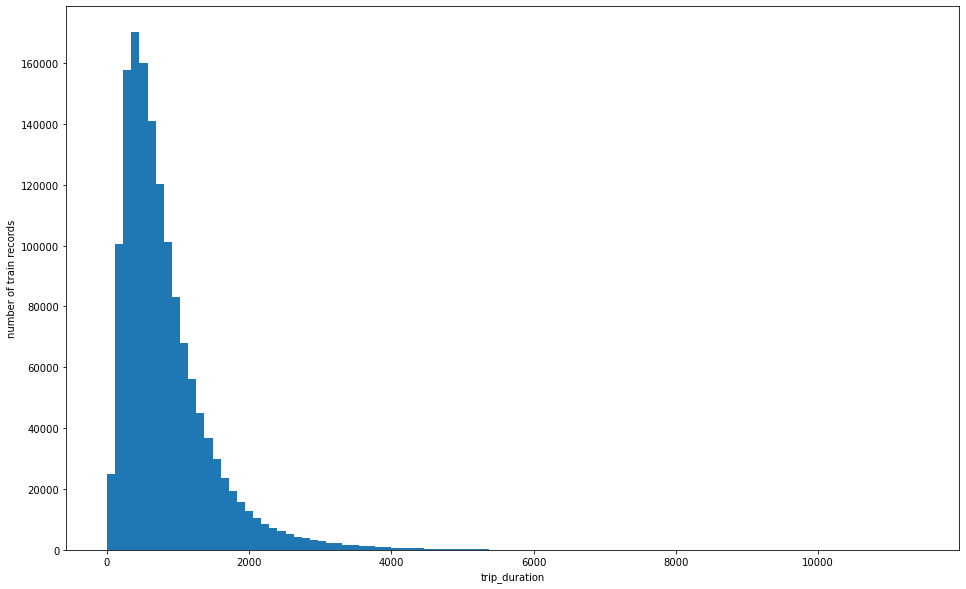

In [12]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

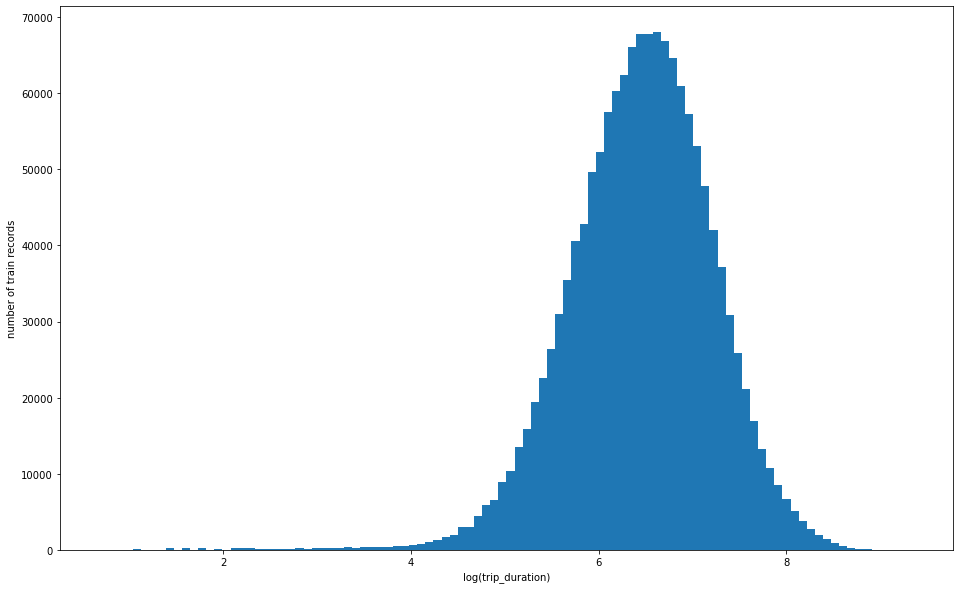

C:\Users\Fajri\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_trip_duration', ylabel='Density'>

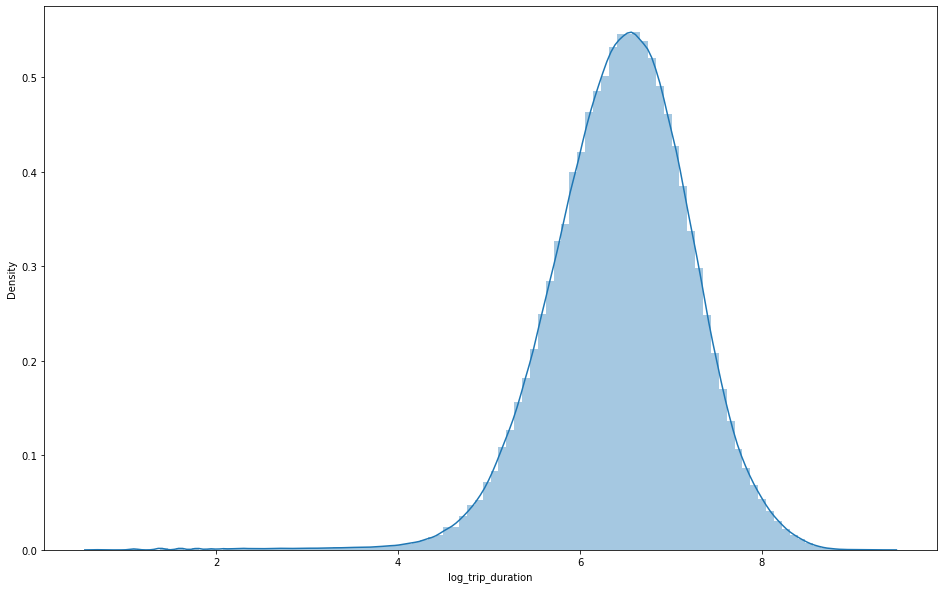

In [13]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()
sns.distplot(train["log_trip_duration"], bins =100)

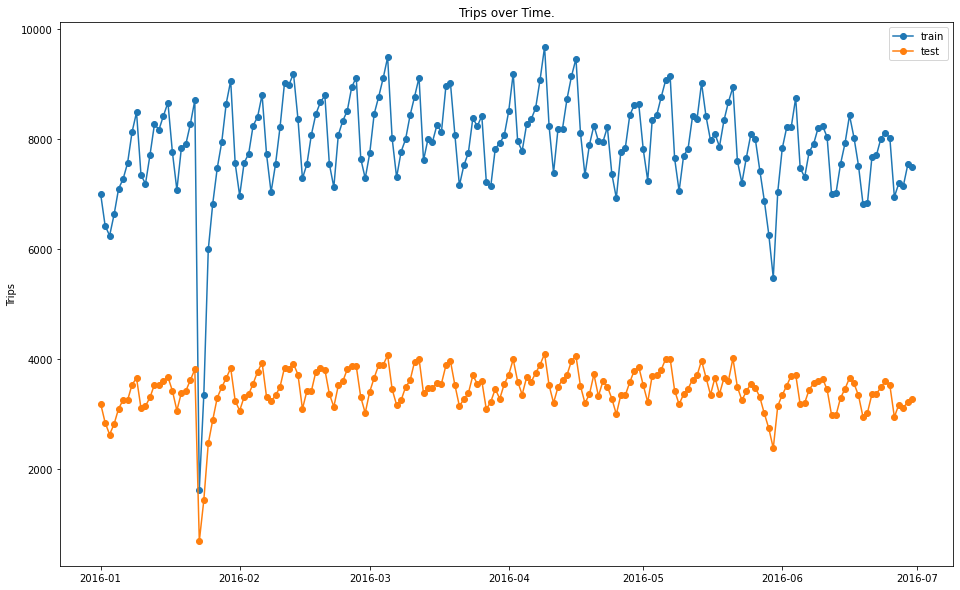

In [14]:
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

No handles with labels found to put in legend.


Text(0, 0.5, 'Time in Seconds')

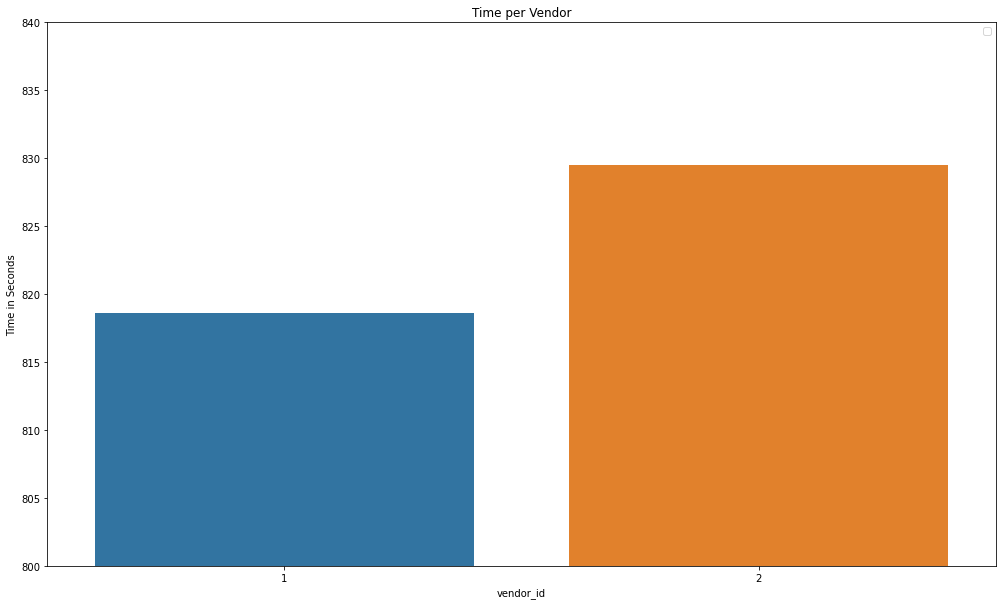

In [15]:
import warnings
warnings.filterwarnings("ignore")
plot_vendor = train.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Time per store_and_fwd_flag'}, xlabel='store_and_fwd_flag', ylabel='Time in Seconds'>

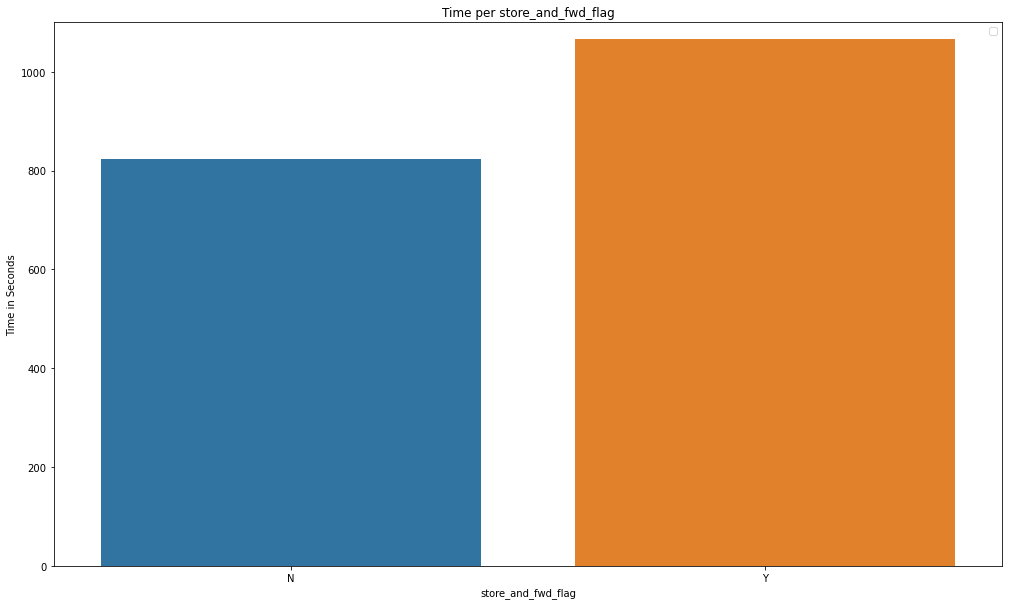

In [16]:
snwflag = train.groupby('store_and_fwd_flag')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(snwflag.index,snwflag.values)

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Time per store_and_fwd_flag'}, xlabel='passenger_count', ylabel='Time in Seconds'>

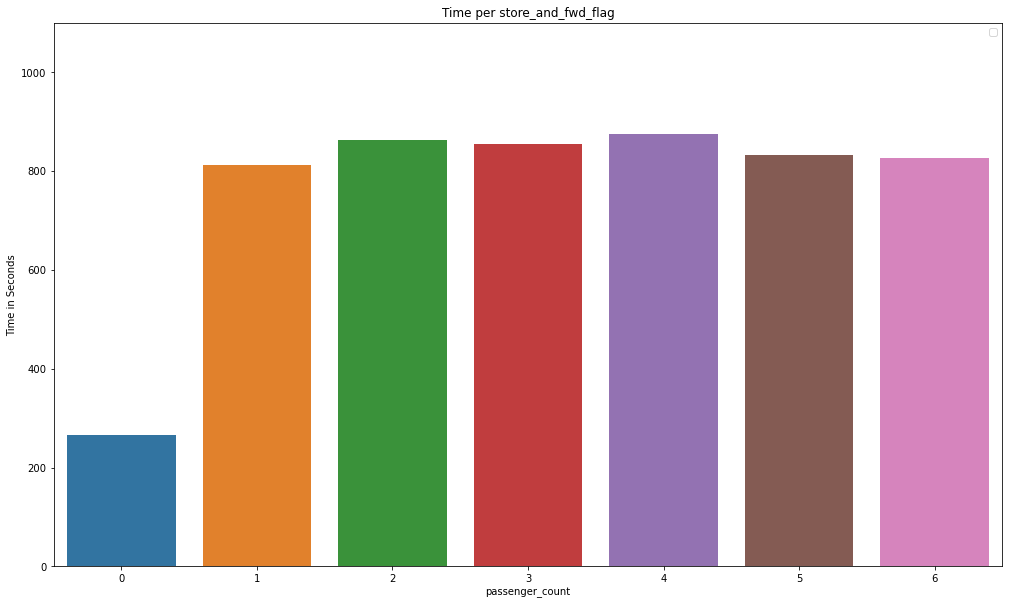

In [17]:
pc = train.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(pc.index,pc.values)

In [18]:
train.groupby('passenger_count').size()

passenger_count
0         52
1    1018715
2     206864
3      58989
4      27957
5      76912
6      47639
dtype: int64

In [19]:
test.groupby('passenger_count').size()


passenger_count
0        23
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
dtype: int64

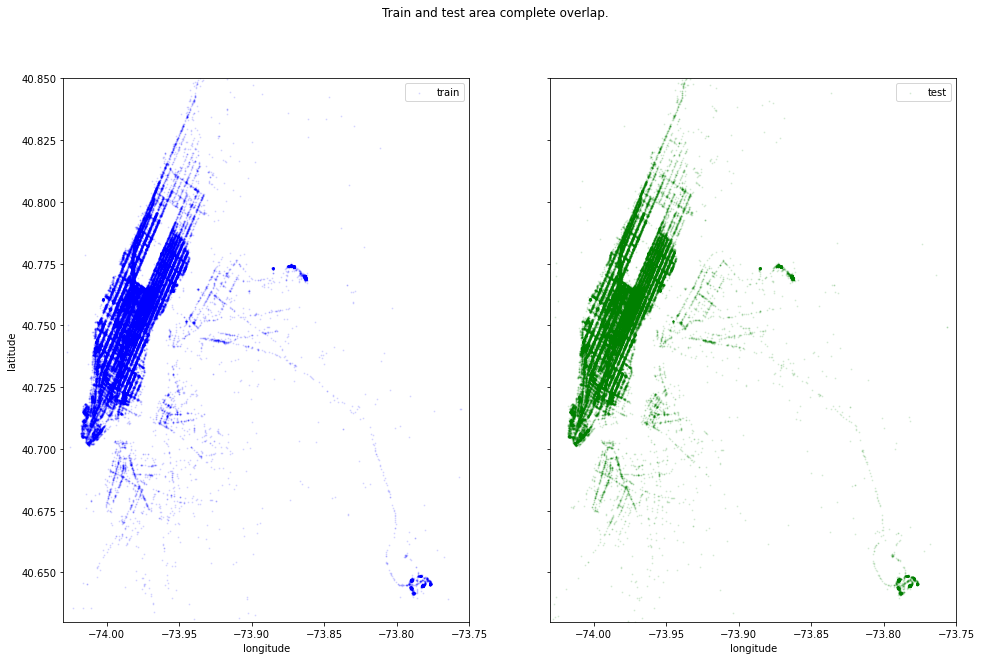

In [20]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [21]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [22]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)    
    
train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

In [23]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [24]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [25]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [26]:
train['pickup_cluster'].value_counts()

94    44674
24    42271
27    40070
12    37385
34    36060
      ...  
14      128
44      128
30      105
71       98
31       88
Name: pickup_cluster, Length: 100, dtype: int64

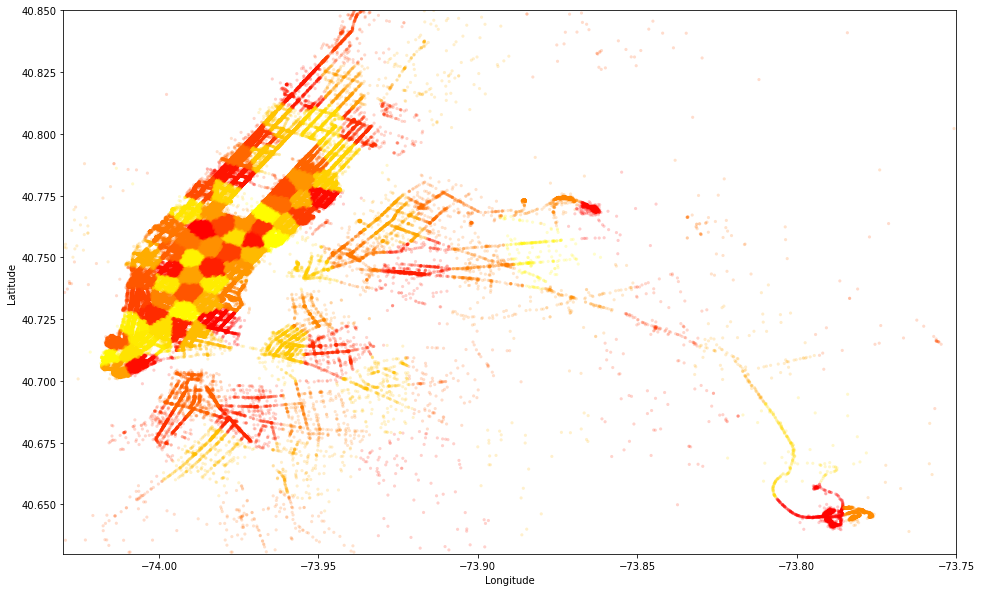

In [27]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [28]:
#Extracting Month
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

In [29]:
train.groupby('Month').size(),test.groupby('Month').size()


(Month
 1    226444
 2    235054
 3    252443
 4    247855
 5    244591
 6    230741
 dtype: int64,
 Month
 1     97676
 2    102314
 3    109697
 4    107432
 5    107570
 6    100445
 dtype: int64)

In [30]:
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day
len(train.groupby('DayofMonth').size()),len(test.groupby('DayofMonth').size())

(31, 31)

In [31]:
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour
len(train.groupby('Hour').size()),len(test.groupby('Hour').size())

(24, 24)

In [32]:
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek
len(train.groupby('dayofweek').size()),len(test.groupby('dayofweek').size())

(7, 7)

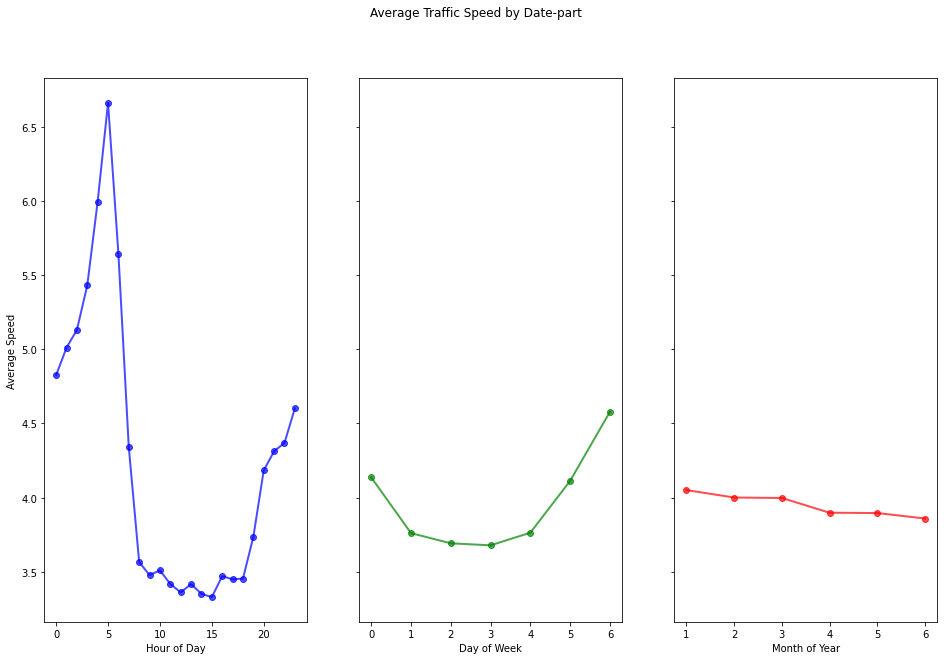

In [33]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('Hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('dayofweek').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('Month').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

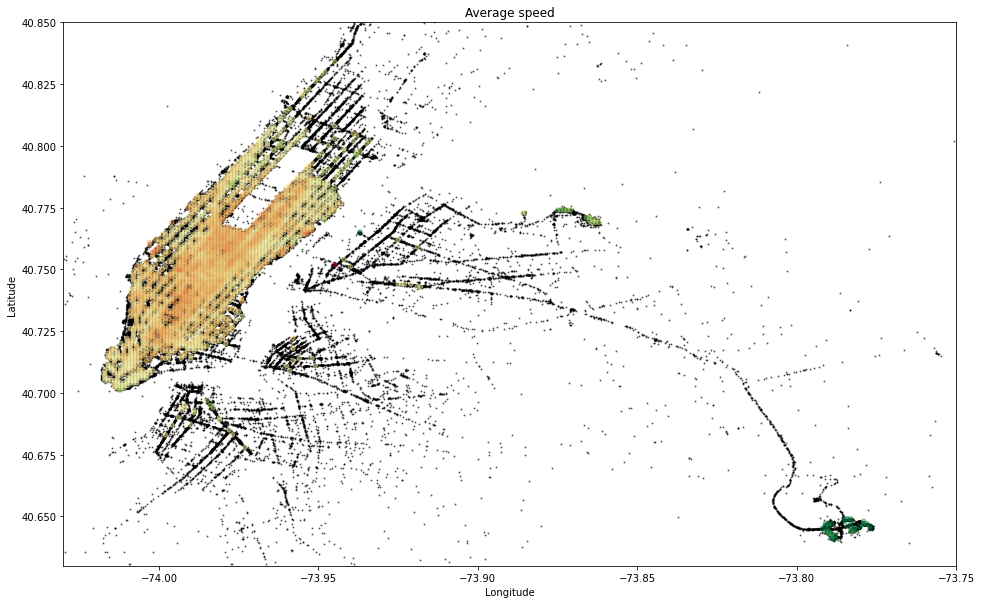

In [34]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values, c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

# Data Encrichment

In [35]:
#fr1 = pd.read_csv('fastest_routes_train_part_1.csv', usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
#fr2 = pd.read_csv('fastest_routes_train_part_2.csv', usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
#test_street_info = pd.read_csv('fastest_routes_test.csv',
                               #usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
#train_street_info = pd.concat((fr1, fr2))
#train = train.merge(train_street_info, how='left', on='id')
#test = test.merge(test_street_info, how='left', on='id')

In [36]:
train.shape, test.shape

((1437128, 26), (625134, 19))

In [37]:
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_pickup_test = pd.get_dummies(test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(train['dropoff_cluster'], prefix='d', prefix_sep='_')
cluster_dropoff_test = pd.get_dummies(test['dropoff_cluster'], prefix='d', prefix_sep='_')

month_train = pd.get_dummies(train['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['DayofMonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['dayofweek'], prefix='dow', prefix_sep='_')

In [38]:
vendor_train.shape,vendor_test.shape

((1437128, 2), (625134, 2))

In [39]:
passenger_count_train.shape,passenger_count_test.shape

((1437128, 7), (625134, 8))

In [40]:
store_and_fwd_flag_train.shape,store_and_fwd_flag_test.shape

((1437128, 2), (625134, 2))

In [41]:
cluster_pickup_train.shape,cluster_pickup_test.shape

((1437128, 100), (625134, 100))

In [42]:
cluster_dropoff_train.shape,cluster_dropoff_test.shape

((1437128, 100), (625134, 100))

In [43]:
month_train.shape,month_test.shape

((1437128, 6), (625134, 6))

In [44]:
dom_train.shape,dom_test.shape

((1437128, 31), (625134, 31))

In [45]:
hour_train.shape,hour_test.shape

((1437128, 24), (625134, 24))

In [46]:
dow_train.shape,dow_test.shape

((1437128, 7), (625134, 7))

In [47]:
passenger_count_test = passenger_count_test.drop('pc_9', axis = 1)

In [48]:
train = train.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)
Test_id = test['id']
test = test.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek',
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1)

train = train.drop(['dropoff_datetime','avg_speed_h','avg_speed_m','pickup_lat_bin','pickup_long_bin','trip_duration'], axis = 1)

In [49]:
train.shape,test.shape

((1437128, 8), (625134, 7))

In [50]:
Train_Master = pd.concat([train,
                          vendor_train,
                          passenger_count_train,
                          store_and_fwd_flag_train,
                          cluster_pickup_train,
                          cluster_dropoff_train,
                         month_train,
                         dom_train,
                          hour_test,
                          dow_train
                         ], axis=1)

In [51]:
Test_master = pd.concat([test, 
                         vendor_test,
                         passenger_count_test,
                         store_and_fwd_flag_test,
                         cluster_pickup_test,
                         cluster_dropoff_test,
                         month_test,
                         dom_test,
                          hour_test,
                          dow_test], axis=1)

In [52]:
Train_Master.shape,Test_master.shape

((1446345, 287), (625134, 286))

In [53]:
Train_Master = Train_Master.drop(['pickup_datetime','pickup_date'],axis = 1)
Test_master = Test_master.drop(['pickup_datetime','pickup_date'],axis = 1)

In [54]:
Train_Master.shape,Test_master.shape

((1446345, 285), (625134, 284))

In [55]:
Train, Test = train_test_split(Train_Master[0:100000], test_size = 0.2)

In [56]:
X_train = Train.drop(['log_trip_duration'], axis=1)
Y_train = Train["log_trip_duration"]
X_test = Test.drop(['log_trip_duration'], axis=1)
Y_test = Test["log_trip_duration"]

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

In [57]:
X_train.shape

(80000, 284)

In [58]:
Y_train.shape

(80000, 1)

In [59]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)
dtest = xgb.DMatrix(Test_master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# XGBosst - Training Model and Testing Accuracy

In [60]:
xgb_pars = {'min_child_weight': 1, 'eta': 0.3, 'colsample_bytree': 0.9, 
            'max_depth': 10,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'mae', 'objective': 'reg:linear', 'colsample_bytree' : 1}
model = xgb.train(xgb_pars, dtrain, 10, watchlist, early_stopping_rounds=20,
      maximize=False, verbose_eval=1)
print("Best MAPE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

[14:35:50] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:50] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mae:nan	valid-mae:nan
[1]	train-mae:nan	valid-mae:nan
[2]	train-mae:nan	valid-mae:nan
[3]	train-mae:nan	valid-mae:nan
[4]	train-mae:nan	valid-mae:nan
[5]	train-mae:nan	valid-mae:nan
[6]	train-mae:nan	valid-mae:nan
[7]	train-mae:nan	valid-mae:nan
[8]	train-mae:nan	valid-mae:nan
[9]	train-mae:nan	valid-mae:nan
Best MAPE: nan with 1 rounds


In [61]:
params = {
    # Parameters that we are going to tune.
    'max_depth':10,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:linear',
}

In [62]:
num_boost_round=999

In [63]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=10,
    metrics={'rmse'},
    early_stopping_rounds=10
)

[14:35:59] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:00] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:01] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:01] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:02] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:03] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:36:04] WARNING: c:\ci\xgboost-split_1619728435298\work\src\objecti

In [64]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

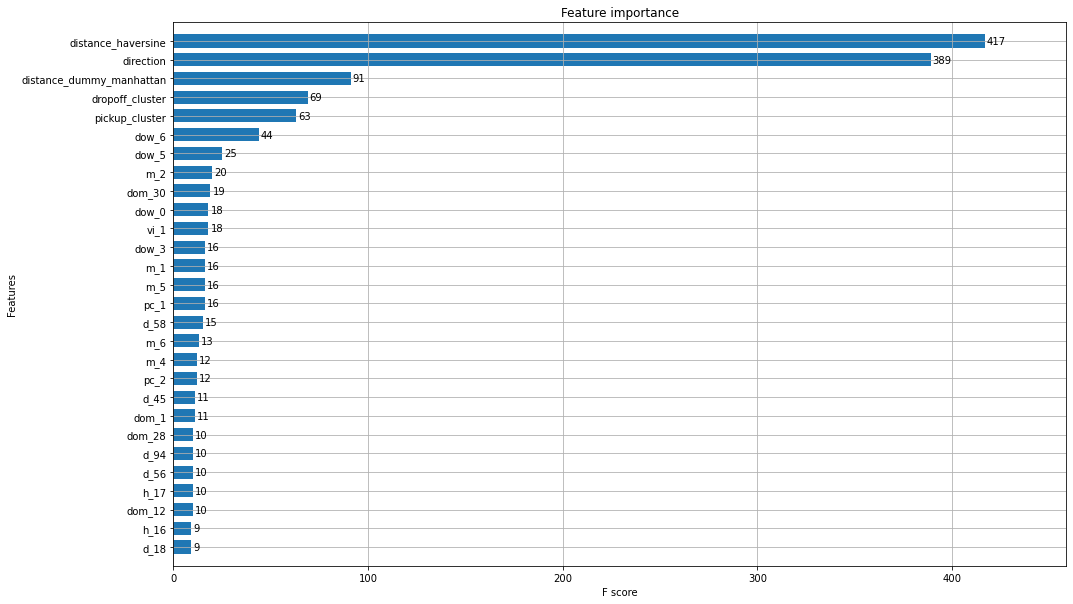

In [65]:
xgb.plot_importance(model, max_num_features=28, height=0.7)

In [66]:
pred = model.predict(dtest)
pred = np.exp(pred) - 1

In [67]:
pred

array([ 818.193  ,  781.84503,  434.6065 , ..., 1112.6185 , 1916.9934 ,
        964.9382 ], dtype=float32)